### 이미지 데이터
* 이미지는 숫자로 이루어져 있고, 일반적으로 RGB 이미지는 기본적으로 0 이상 255 이하의 값이며 그 이미지 값을 이용해 이미지 크기 조정, 값의 스케일링, 이미지 변환, 노이즈 제거 등 다양한 연구들이 진행되고 있다.
* 이를 이미지 처리 (Image processing)이라고 한다.
* 이미지는 픽셀이라는 기본 단위가 존재하며 이미지 데이터는 기본 단위로 구성된 행렬이다.
* 흑백 이미지의 경우, 이미지 크기는 128x128x1이며 1을 채널(Channel)이라고 말한다.
* RGB 이미지는 빨강, 초록, 파랑 채널의 값들이 적절히 합쳐져 색을 결정하는 형태로써 128x128x3 이미지라고 할 수 있다.


### MLP와 이미지 처리
* MLP 구조를 이용하여 사각형 모양의 사진을 처리하려면 이미지를 일렬 형태로 변환 후 모델에 입력시켜야만 한다.
* 예를 들어 3x3 이미지 행렬은 9x1 벡터가 되어 모델에 들어가게 되고 모델은 일렬 형태의 이미지 벡터를 통해 학습을 한다.
* 문제는 이미지 내에 같은 객체가 있더라도 그 위치나 크기가 조금만 달라져도 벡터는 크게 변화할 수 있다.
* 같은 객체라도 완전히 다른 벡터로 변환되어 객체의 공통된 특성을 뽑아낼 수 없을 가능성이 커진다.
* 따라서 전체 이미지를 벡터화하지 않고 이미지의 일부분을 하나씩 살펴 보면서 전체 이미지를 해석할 필요가 있다.
* 이것이 CNN의 기본 개념이자 핵심 포인트이다.

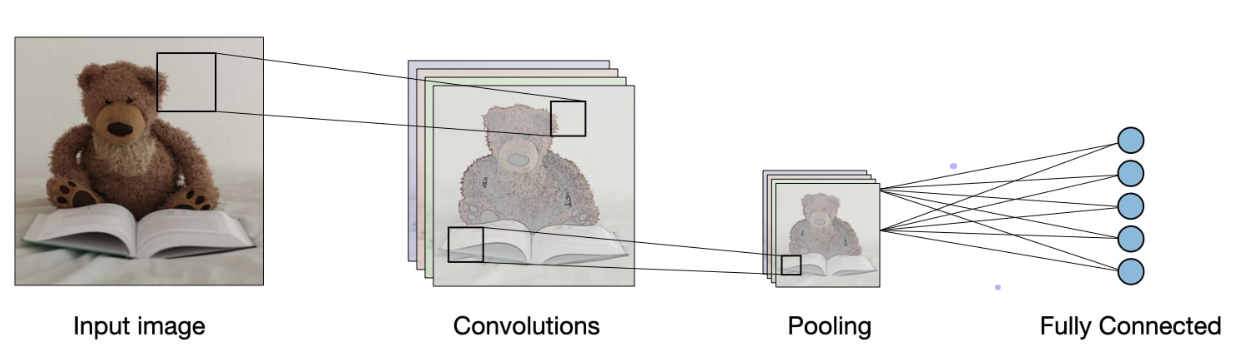

### 합성곱 연산
* 필터가 위치한 부분에서 동일한 위치의 성분끼리 곱하여 전체를 더하는 것이다.
* 필터가 움직이는 보폭(Stride)을 정할 수 있으며 이미지 밖을 특정 값으로 둘러쌓는 패딩(Padding)을 이용할 수도 있다.

### 풀링 연산
* 최대값 풀링(Max pooling) : 일반적으로 영역 내에서 최대값을 뽑아낸다.
* 평균값 풀링(Average pooling) : 평균값을 뽑아낸다.
* 풀링은 영역별 대표값을 하나씩 뽑아내는 연산이며 주로 컨볼루션 층 다음에 배치한다.

### AlexNet


##### 라이브러리 불러오기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

##### CIFAR10 데이터 세트 불러오기
* transforms.Normalize은 특정 평균과 표준편차를 따르는 정규분포를 통해 이미지를 표준화하는 방법이다.
* CIFAR10은 3채널 컬러 이미지이므로 각 장의 평균과 표준편차를 정한다.


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 41637013.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


##### GPU 연산 체크하기

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


### AlexNet 구축하기
* AlexNet은 ImageNet 데이터를 위해 만들어 졌다.
* ImageNet은 1000개의 클래스로 분류되어 있는 256x256 또는 224x224 크기를 갖는 이미지이다.
* 따라서 크기가 32x32인 CIFAR10 이미지는 제대로 동작을 안 할 수 있다.
* 따라서 데이터에 맞게 필터의 크기와 보폭 수를 조정해 모델을 구축한다.


In [4]:
class AlexNet(nn.Module): # AlexNet 클래스는 nn.Module 클래스를 상속받는다.
    def __init__(self):
        super(AlexNet, self).__init__()
        # features는 이미지의 특징을 추출하는 부분으로,
        # 여러 개의 합성곱(Convolutional) 레이어와 활성화 함수 ReLU, 최대 풀링(Max Pooling) 레이어로 구성된다.
        # nn.Conv2d(3, 64, 3)에서 각각의 숫자는 합성곱(Convolutional) 레이어의 입력 채널 수, 출력 채널 수, 커널(필터) 크기를 의미한다.
        # 첫 번째 숫자 3은 입력 채널 수이다. 이 경우에는 입력 이미지의 채널 수가 3인 RGB 이미지를 의미한다.
        # 두 번째 숫자 64는 출력 채널 수이다. 이는 합성곱 레이어가 생성하는 특징 맵의 개수를 나타낸다.
        # 즉, 64개의 서로 다른 특징 맵이 생성된다.
        # 세 번째 숫자 3은 커널(필터) 크기이다.
        # 이는 합성곱 연산에 사용되는 필터의 크기를 나타낸다. 여기서는 3x3 크기의 필터를 사용한다.
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # classifier는 추출된 특징을 기반으로 이미지를 분류하는 부분으로,
        # 여러 개의 선형 레이어와 드롭아웃(Dropout) 레이어로 구성된다.
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    # forward 메서드에서는 입력 이미지를 모델에 통과시켜 출력을 계산한다.
    # 먼저 features를 통과한 후에는 view 메서드를 사용하여 텐서의 크기를 조정한다.
    # 그리고 classifier를 통과하여 최종 분류 결과를 얻는다.
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256 * 3 * 3)
        x = self.classifier(x)
        return x

#### 손실 함수 및 최적화 방법 정의하기

In [5]:
criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(),lr=1e-3)

#### AlexNet 모델 학습하기

In [6]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n = len(trainloader) # 배치 개수
for epoch in range(50):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터
    optimizer.zero_grad()
    outputs = alexnet(inputs) # 예측값 산출
    loss = criterion(outputs, labels) # 손실 함수 계산
    loss.backward() # 손실 함수 기준으로 역전파 선언
    optimizer.step() # 가중치 최적화
    running_loss += loss.item()

  loss_.append(running_loss/n)
  print('[%d] loss: %.3f' %(epoch+1, running_loss / len(trainloader)))

[1] loss: 1.571
[2] loss: 1.149
[3] loss: 0.961
[4] loss: 0.841
[5] loss: 0.763
[6] loss: 0.701
[7] loss: 0.652
[8] loss: 0.601
[9] loss: 0.561
[10] loss: 0.530
[11] loss: 0.498
[12] loss: 0.482
[13] loss: 0.456
[14] loss: 0.430
[15] loss: 0.412
[16] loss: 0.396
[17] loss: 0.373
[18] loss: 0.360
[19] loss: 0.344
[20] loss: 0.338
[21] loss: 0.324
[22] loss: 0.310
[23] loss: 0.301
[24] loss: 0.290
[25] loss: 0.274
[26] loss: 0.284
[27] loss: 0.277
[28] loss: 0.256
[29] loss: 0.262
[30] loss: 0.254
[31] loss: 0.235
[32] loss: 0.247
[33] loss: 0.244
[34] loss: 0.241
[35] loss: 0.229
[36] loss: 0.247
[37] loss: 0.217
[38] loss: 0.233
[39] loss: 0.222
[40] loss: 0.238
[41] loss: 0.207
[42] loss: 0.236
[43] loss: 0.218
[44] loss: 0.227
[45] loss: 0.219
[46] loss: 0.210
[47] loss: 0.228
[48] loss: 0.202
[49] loss: 0.234
[50] loss: 0.234


#### 학습 손실 함수 그래프 그리기

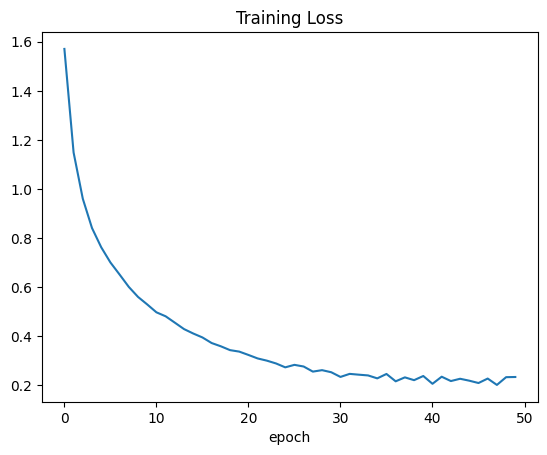

In [7]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

#### 파이토치 모델 저장 및 불러오기
* 평가가 잘 되었다면, 추후 이어서 학습을 하거나 실험 자료를 남기기 위해 모델을 저장해야 한다.

In [16]:
PATH = '/models/cifar_alexnet.pth'
torch.save(alexnet.state_dict(), PATH)

In [17]:
alexnet = AlexNet().to(device)
alexnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### 평가하기

In [19]:
correct = 0
total = 0
with torch.no_grad():
  alexnet.eval()
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device) # 'lables'를 'labels'로 수정
    outputs = alexnet(images)
    _, predicted = torch.max(outputs,1)
    total += labels.size(0) # 개수 누적(총 개수)
    correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

print('Test accuracy: %.2f %%' %(100*correct/total))

Test accuracy: 10.00 %


### ResNet
* Skip connection은 여러 레이어를 건너 뛰어 이전 정보를 더하는 것을 의미하며, 이 하나의 과정을 묶어 만든 것이 Residual block이다.
* Residual block의 위치나 구조에 따라 성능이 달라질 수 있지만, 기본적으로 합성곱 층 2, 3칸을 뛰어넘어 더하는 방식을 사용한다.
* ResNet은 Residual block 여러 개를 붙여놓은 모델이며, 모델명에 붙은 숫자는 층의 개수를 의미한다.
* ResNet18은 층이 18개이고, ResNet34는 34개의 층을 가지고 있는 모델이다.
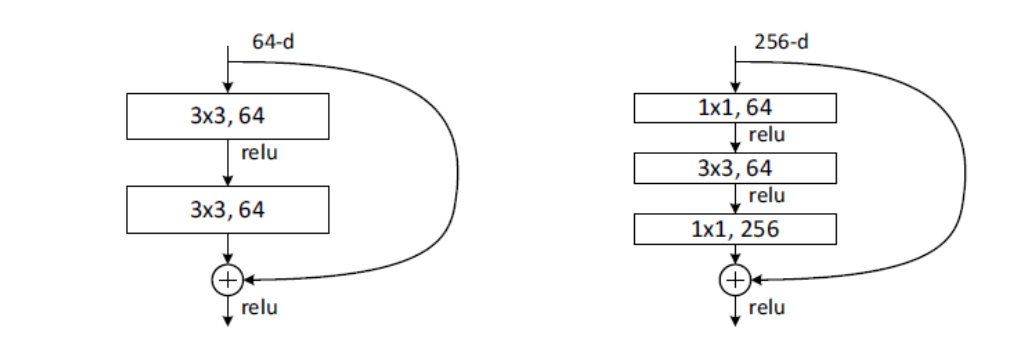

* ImageNet 데이터에 맞춰진 ResNet은 기본층에서 7x7 필터를 사용하는 합성곱과 3x3 맥스 풀링을 사용한다.
* CIFAR10은 이미지 사이즈가 ImageNet 이미지 보다 훨씬 작기 때문에 기본층의 합성곱 필터 사이즈를 3x3으로 줄이고 맥스풀링을 생략한다.

#### Residual block 구축하기

In [20]:
class ResidualBlock(nn.Module):
  def __init__(self,in_channels,out_channels,stride=1):
    super(ResidualBlock,self).__init__()
    self.stride=stride
    self.in_channels=in_channels # in_channels은 입력 채널 수
    self.out_channels=out_channels # out_channels는 출력 채널 수
    self.conv_block=nn.Sequential(
        nn.Conv2d(self.in_channels, self.out_chennels, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(self.out_channels), nn.ReLU(),
        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(self.out_channels))
    # downsample은 스트라이드 값이 1이 아니거나 입력 채널 수와 출력 채널 수가 다를 때, 입력을 다운샘플링하기 위한 연산을 정의하는 부분이다.
    if self.stride!=1 or self.in_channels!=self.out_channels: #
      self.downsample=nn.Sequential(
          nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.out_channels))
  # forward 메서드에서는 입력을 Residual Block에 통과시켜 출력을 계산한다.
  # 먼저 conv_block을 통과한 후, 입력 채널 수와 출력 채널 수가 다르거나 스트라이드 값이 1이 아닌 경우에는
  # downsample을 통과하여 입력을 다운샘플링한다.
  # 그리고 입력과 conv_block의 출력을 더한 후 ReLU 활성화 함수를 적용하여 최종 출력을 얻는다.
  def forward(self, x):
    out=self.conv_block(x)
    if self.stride!=1 or self.in_channels!=self.out_channels:
      x=self.downsample(x)
    out=F.relu(x+out)
    return out

#### ResNet 모델 구축하기

In [21]:
class ResNet(nn.Module):
  # num_blocks는 각 레이어에서 사용할 Residual Block의 개수를 나타내는 리스트이다.
  # num_classes는 분류할 클래스의 개수로, 기본값은 10으로 설정되어 있다.
  # layers1, layers2, layers3, layers4는 각각 ResNet의 두 번째, 세 번째, 네 번째, 다섯 번째 레이어로,
  # _make_layer 메서드를 사용하여 Residual Block을 여러 번 쌓은 형태로 구성된다.
  def __int__(self, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels=64
    self.base=nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU())
    self.layers1=self._make_layer(64,num_blocks[0],stride=1)
    self.layers2=self._make_layer(128,num_blocks[1],stride=2)
    self.layers3=self._make_layer(256,num_blocks[2],stride=2)
    self.layers4=self._make_layer(512,num_blocks[3],stride=2)
    # gap은 Global Average Pooling을 수행하는 레이어로, 입력을 4x4 크기로 평균 풀링한다.
    self.gap=nn.AvgPool2d(4)
    # fc는 마지막 Fully Connected 레이어로, 입력 크기가 512이고 출력 크기가 num_classes인 선형 레이어이다.
    self.fc=nn.Linear(512,num_classes)

  def _make_layer(self, out_channels, num_block, stride):
    strides=[stride]+[1]*(num_block-1)
    layers=[]
    for stride in strides:
      block=ResidualBlock(self.in_channels, out_channels, stride)
      layers.append(block)
      self.in_channels=out_channels
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.base(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.gap(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out

In [25]:
from torchvision.models import resnet18, resnet34

def modeltype(model):
    if model == 'resnet18':
        return resnet18()

    elif model == 'resnet34':
        return resnet34()

resnet = modeltype('resnet18').to(device)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
# 모델 저장 경로
PATH = '/models/cifar_resnet.pth'

In [27]:
# CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [28]:
# 모델의 학습 과정인 4강에서 배운 인공 신경망과 동일하다.
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n = len(trainloader) # 배치 개수

for epoch in range(10):  # 10번 학습을 진행한다.

    running_loss = 0.0
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터

        optimizer.zero_grad()
        outputs = resnet(inputs) # 예측값 산출
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    loss_.append(running_loss / n)
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / n))

# AlexNet: 0.207 (epoch 50)
# ResNet: 0.083 (epoch 10)

[1] loss: 1.442
[2] loss: 1.026
[3] loss: 0.847
[4] loss: 0.718
[5] loss: 0.603
[6] loss: 0.507
[7] loss: 0.422
[8] loss: 0.337
[9] loss: 0.274
[10] loss: 0.219


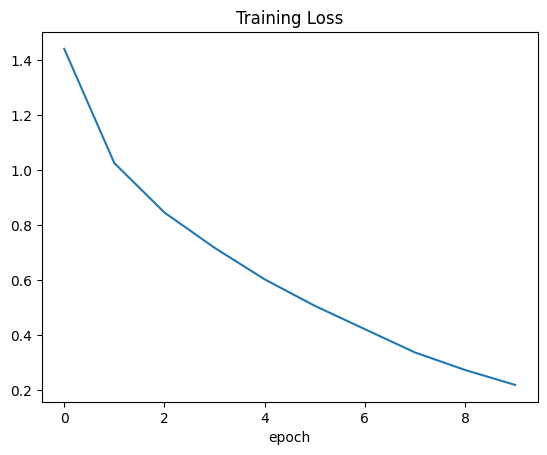

In [29]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [32]:
# 모델 저장
torch.save(resnet.state_dict(), PATH)

In [33]:
# 모델 파라메타 불러오기
resnet = modeltype('resnet18').to(device)
resnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [34]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    resnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

print('Test accuracy: %.2f %%' % (100 * correct / total))

# AlexNet: Test accuracy: 76.66 %
# ResNet: Test accuracy: 83.25 %

Test accuracy: 76.50 %
